# Full Workbench disease network
This is a study-study similarity network constructed from hundreds of available studies in Metabolomics Workbench. Studies are linked by the metabolites present and named (by REFMET) in each study. 

1. Pull studies from Workbench API with REFMET
2. Threshold on number of REFMET compounds (if wanted)
3. Build bipartite graph with only overlapping compounds

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import networkx as nx
from networkx.algorithms import bipartite
import itertools

In [2]:
# get disease associations
disease_url = 'https://www.metabolomicsworkbench.org/rest/study/study_id/ST/disease'
disease_assoc = requests.get(disease_url)
disease_json = disease_assoc.json()

In [3]:
disease_assoc_df = pd.DataFrame.from_dict(disease_json, orient='index')

In [4]:
disease_assoc_df.to_csv('Disease_association_Workbench.csv')

In [5]:
disease_assoc_df = pd.read_csv('Disease_association_Workbench.csv', index_col=0)

In [6]:
disease_assoc_df['Disease'].value_counts()

Disease
Cancer                                         422
Diabetes                                       104
Obesity                                         64
Environmental exposure                          48
Malaria                                         45
                                              ... 
Alopecia                                         1
Cerebellar ataxia                                1
Hypercortisolemia                                1
Sarcoidosis                                      1
Inflammatory bowel disease; Crohn's disease      1
Name: count, Length: 207, dtype: int64

In [21]:
disease_assoc_df['Disease'].value_counts().head(10).reset_index()

,Disease,count
0,Cancer,402
1,Diabetes,103
2,Obesity,63
3,Malaria,45
4,Environmental exposure,43
5,Eye disease,37
6,Fatty liver disease,37
7,Heart disease,33
8,Tuberculosis,28
9,Spinal cord injury,26


/var/tmp/pbs.9869320.pbs/ipykernel_371487/1372025088.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


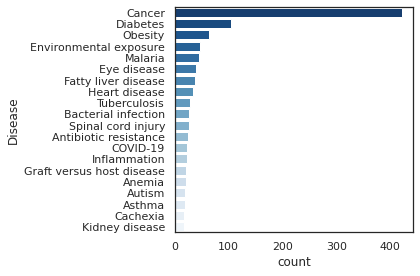

In [8]:
# plot top 10 diseases
sns.set(
    style='white'
)
sns.barplot(
    data=disease_assoc_df['Disease'].value_counts().head(20).reset_index(),
    x='count',
    y='Disease',
    palette='Blues_r'
)

plt.tight_layout()
plt.show()

## Download all study data - not needed (only if interested in DA metabolites)
Only REFMET are required

In [9]:
named_met_url = 'https://www.metabolomicsworkbench.org/rest/study/study_id/ST/named_metabolites/'
named_met_dat = requests.get(named_met_url)
named_met_json = named_met_dat.json()
named_met_df = pd.DataFrame.from_dict(named_met_json, orient='index')

In [10]:
named_met_df.to_csv('Named_metabolites_Workbench.csv')

In [11]:
named_met_df = pd.read_csv('Named_metabolites_Workbench.csv', index_col=0)

In [12]:
named_met_df.sort_values(by='num_metabolites').head()


,study_id,study_title,institute,analysis_id,analysis_type,units,num_metabolites,details,species
1194,ST001089,Host NLRP6 exacerbates graft-versus-host disea...,University of Michigan,AN001774,MS,M/100mg stool,1,HILIC POSITIVE ION MODE,Mus musculus
2353,ST002282,Detection of Methyl jasmonate (MeJA) in Plant ...,National University of Singapore,AN003727,MS,ion intensity peak area,1,GC UNSPECIFIED ION MODE,Arabidopsis thaliana
2339,ST002269,Targeted plasma metabolomics in pediatric NAFL...,Seoul National University College of Medicine ...,AN003707,MS,μM,1,Reversed phase POSITIVE ION MODE,Homo sapiens
2780,ST002702,A targeted metabolomics approach for sepsis-in...,Asan Medical Center,AN004381,MS,ug/uL,1,Reversed phase NEGATIVE ION MODE,Homo sapiens
1855,ST001837,Quantitative total hexose study on blood serum...,Helmholtz Centre for Environmental Research,AN002979,MS,µM,1,Reversed phase NEGATIVE ION MODE,Rattus norvegicus


In [24]:
# filter for at least 100 named mets - change this (high value to save time downloading)
named_met_df['num_metabolites'] = named_met_df['num_metabolites'].astype(int)
named_met_df_filt = named_met_df[named_met_df['num_metabolites'] >= 450]

In [10]:
named_met_df_filt

,study_id,study_title,institute,analysis_id,analysis_type,units,num_metabolites,details,species
12,ST000005,Timecourse on RAW 264.7 cells treated with Kdo...,LIPID MAPS,AN000012,MS,pmol/ug DNA,546,Combined analysis,Mus musculus
17,ST000010,Lung Cancer Cells 4,University of Michigan,AN000025,MS,Peak area,250,LC/Electro-spray /QTOF positive ion mode,Homo sapiens
25,ST000016,NPM-ALK metabolic regulation,University of Michigan,AN000033,MS,Peak area,500,LC/MS positive ion mode,Homo sapiens
26,ST000017,Rat HCR/LCR Stamina Study,University of Michigan,AN000034,MS,peak area,423,LC/Electro-spray /QTOF positive ion mode,Rattus norvegicus
30,ST000040,Heatshock response of C. elegans using IROA (I),University of Florida,AN000060,MS,Peak area,280,MS positive ion mode,Caenorhabditis elegans
...,...,...,...,...,...,...,...,...,...
3268,ST003243,"Lipidomic analysis of serum from WT, liver-spe...",University of Rochester Medical Center,AN005313,MS,Normalized to the median value of total lipid ...,370,Reversed phase POSITIVE ION MODE,Mus musculus
3269,ST003249,Mitochondrial respiration impairment in microg...,Northwestern University,AN005322,MS,Peak area,294,HILIC UNSPECIFIED ION MODE,Mus musculus
3270,ST003250,Lipidomic analysis of Axon Regeneration in Xen...,University of Miami,AN005323,MS,peak area,967,Reversed phase POSITIVE ION MODE,Xenopus laevis
3271,ST003250,Lipidomic analysis of Axon Regeneration in Xen...,University of Miami,AN005324,MS,peak area,631,Reversed phase NEGATIVE ION MODE,Xenopus laevis


In [14]:
named_met_df_filt['details'].value_counts()

details
Reversed phase POSITIVE ION MODE         266
Reversed phase NEGATIVE ION MODE         161
HILIC POSITIVE ION MODE                  152
HILIC NEGATIVE ION MODE                   95
HILIC UNSPECIFIED ION MODE                85
                                        ... 
GC POSITIVE ION MODE/Metabolites set2      1
GC POSITIVE ION MODE/Metabolites set1      1
Biocrates P-180                            1
CE-TOF MS                                  1
Combined GC/LC UNSPECIFIED ION MODE        1
Name: count, Length: 127, dtype: int64

In [25]:
studies = list(set(named_met_df_filt['study_id'].tolist()))
# studies_assays = dict.fromkeys(studies)

In [12]:

# # Get assays for each study
# for s in tqdm(studies):
#     # progress bar
#     base_url = 'https://www.metabolomicsworkbench.org/rest/study/study_id/repl/analysis'
#     resp = requests.get(base_url.replace('repl', s)).json()
#     if list(resp.keys())[0] != '1':
#         resp_series = pd.Series(resp)
#         studies_assays[s] = [resp_series['analysis_id']]
#     else:
#         resp_df = pd.DataFrame.from_dict(resp).T
#         studies_assays[s] = resp_df['analysis_id'].tolist()

100%|██████████| 473/473 [07:59<00:00,  1.01s/it]


In [21]:
len(studies)

496

In [ ]:
# # download all assays per study
# for study in studies:
#     print(study)
#     base_url = 'https://www.metabolomicsworkbench.org/rest/study/analysis_id/'
#     #check if directory exists
#     if not os.path.isdir('Studies_all/'+study):
#         os.mkdir('Studies_all/'+study)

#         for assay in studies_assays[study]:
#             url = base_url + assay + '/datatable/file'
#             print(url)
#             pd.read_csv(url, sep='\t').to_csv('Studies_all/'+study+'/'+f'{assay}.csv', index=False)
#     else:
#         pass

Concatenate all assays and extract REFMET names

In [248]:
studies[0]

'ST000310'

In [17]:
def get_refmets(study_id):
    mets_url = 'https://www.metabolomicsworkbench.org/rest/study/study_id/repl/metabolites'
    mets = requests.get(mets_url.replace('repl', study_id)).json()
    mets_df = pd.DataFrame.from_dict(mets, orient='index')
    refmets = set(mets_df['refmet_name'].tolist())
    return refmets

Now we need to find a computationally efficient way to store all REFMETS from each study and then find the overlapping REFMETS between studies.

Ideas:
- dict with refmets as keys. Values are lists of studies that contain that refmet
- Matrix with studies as rows and refmets as columns. 1 if refmet is in study, 0 otherwise
    - Convert to biadj matrix


In [26]:
refmets_all = []
studies_without_refmets = []
# connections_all = []
for s in tqdm(studies):
    try:
        refmets_all.append(get_refmets(s))
    except KeyError:
        print(s)
        studies_without_refmets.append(s)
        continue
    # connections_all.append(get_refmets(s)[1])


  0%|          | 1/264 [00:00<02:36,  1.68it/s]

ST001471


 13%|█▎        | 35/264 [01:10<04:56,  1.29s/it]

ST001449


 17%|█▋        | 46/264 [01:36<04:39,  1.28s/it]

ST001475


 25%|██▌       | 66/264 [02:29<13:35,  4.12s/it]

ST001469


 47%|████▋     | 124/264 [09:06<09:08,  3.91s/it]

ST001473


 55%|█████▌    | 146/264 [11:29<05:39,  2.88s/it]

ST000357


 70%|███████   | 185/264 [15:11<09:02,  6.87s/it]

ST001636


 82%|████████▏ | 217/264 [19:13<06:18,  8.05s/it]

ST000359


 91%|█████████ | 240/264 [22:38<01:03,  2.64s/it]

ST000361


100%|██████████| 264/264 [24:02<00:00,  5.46s/it]

ST000363


In [27]:
# remove studies without refmets from the study list
studies = [s for s in studies if s not in studies_without_refmets]

In [28]:
len(refmets_all)

254

## Create adjacency matrix

In [30]:
# initialise empty numpy array
adj_mat = np.zeros((len(studies), len(studies)))

# fill in adjacency matrix
combinations = list(itertools.combinations(studies, 2))
for c in combinations:
    i = studies.index(c[0])
    j = studies.index(c[1])
    adj_mat[i, j] = len(refmets_all[i].intersection(refmets_all[j]))
    adj_mat[j, i] = len(refmets_all[i].intersection(refmets_all[j]))



In [31]:
adj_df = pd.DataFrame(adj_mat, index=studies, columns=studies)

In [32]:
# remove studies with no connection to anything
adj_df = adj_df[adj_df.sum(axis=1) > 0]

In [33]:
adj_df.shape

(254, 254)

In [34]:
adj_df.to_csv('adjacency_matrix_full_net.csv')

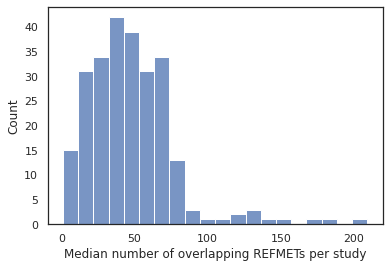

In [35]:
# mean number of connections
sns.set(
    style='white'

)
sns.histplot(
    data=adj_df.median()
)
plt.xlabel('Median number of overlapping REFMETs per study')
plt.show()

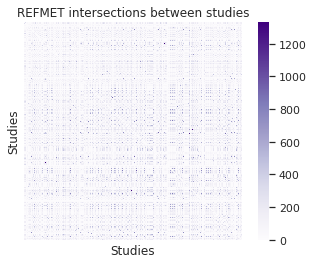

In [36]:
sns.set(
    style='white'
)
ax = sns.heatmap(
    data=adj_df,
    square=True,
    cmap='Purples',
    yticklabels=False,
    xticklabels=False
)

ax.set_title('REFMET intersections between studies')
ax.set_xlabel('Studies')
ax.set_ylabel('Studies')
plt.show()

/rds/general/user/cw2019/home/anaconda3/envs/py10/lib/python3.10/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/rds/general/user/cw2019/home/anaconda3/envs/py10/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/rds/general/user/cw2019/home/anaconda3/envs/py10/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/rds/general/user/cw2019/home/anaconda3/envs/py10/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/rds/general/user/cw2019/home/anaconda3/envs/py10/lib/python3.10/site-

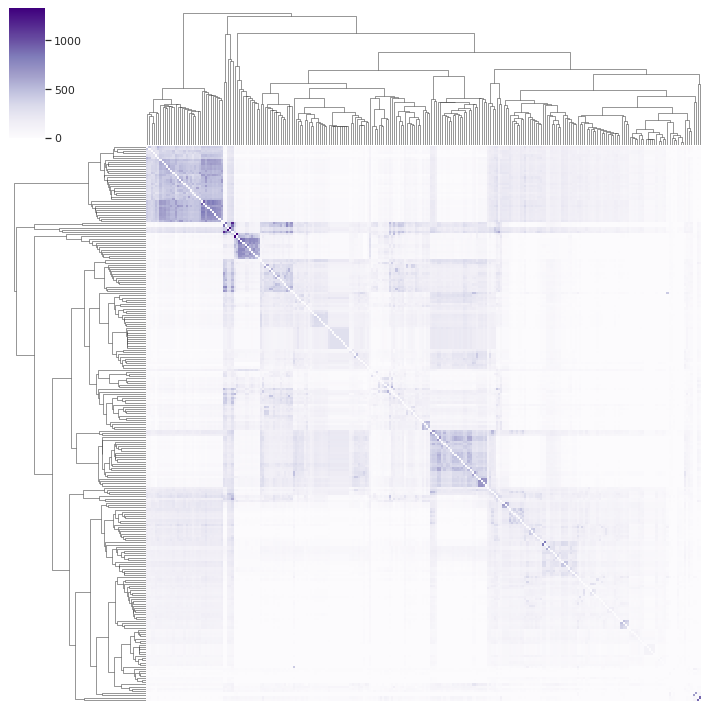

In [37]:
sns.set(
    style='white'
)
ax = sns.clustermap(
    data=adj_df,
    square=True,
    cmap='Purples',
    yticklabels=False,
    xticklabels=False
)

# # ax.set_title('REFMET intersections between studies')
# ax.set_xlabel('Studies')
# ax.set_ylabel('Studies')
plt.show()

### Nx network and disease associations

In [38]:
adj_mat_edgelist = adj_df.melt(ignore_index=False, value_name='weight').reset_index()
adj_mat_edgelist = adj_mat_edgelist[adj_mat_edgelist['weight'] > 0]

In [39]:
adj_mat_edgelist.head()

,index,variable,weight
1,ST002671,ST002631,307.0
2,ST002586,ST002631,2.0
3,ST002195,ST002631,37.0
4,ST003280,ST002631,9.0
5,ST000046,ST002631,3.0


In [40]:
disease_assoc_df.head()

,Study ID,Disease
1,ST000007,Bacterial infection
2,ST000010,Cancer
3,ST000020,Osteoarthritis
4,ST000022,Osteoarthritis
5,ST000026,Antibiotic resistance


In [41]:
disease_assoc_df = disease_assoc_df.drop_duplicates(subset=['Study ID'])

In [299]:
disease_assoc_df[disease_assoc_df['Study ID'] == 'ST000310']

,Study ID,Disease
91,ST000310,Lupus


In [42]:
disease_net = nx.from_pandas_edgelist(
    df=adj_mat_edgelist,
    source='index',
    target='variable',
    edge_attr='weight'
)

In [43]:
# add disease assoc as node attribute
disease_dict = disease_assoc_df.set_index('Study ID', drop=True).to_dict(orient='index')

# assigne each node its properties from nodes_dict
nx.set_node_attributes(disease_net, disease_dict)


In [45]:
assay_df = named_met_df_filt[['study_id', 'details']].drop_duplicates()

In [46]:
assay_df = assay_df.drop_duplicates(subset=['study_id'])

In [47]:
# add assay details as node attribute
assay_dict = assay_df.set_index('study_id').to_dict(orient='index')

nx.set_node_attributes(disease_net, assay_dict)


In [48]:
# remove nodes with empty association attribute 
disease_net.remove_nodes_from([n for n in disease_net.nodes() if disease_net.nodes[n] == {}])

In [49]:
disease_net.number_of_nodes()

254

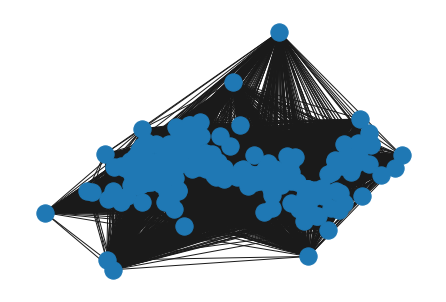

In [50]:
# quick visualisation
nx.draw(
    disease_net,
    pos=nx.spring_layout(disease_net))

In [88]:
# export network to graphml
nx.write_graphml(disease_net, 'WorkBench_full_REFMET_overlap.graphml')

## Create bi-adjacency matrix (bipartite graph)
- Shows exactly which refmets are shared between studies

In [53]:
studies

['ST002631',
 'ST002671',
 'ST002586',
 'ST002195',
 'ST003280',
 'ST000046',
 'ST000044',
 'ST003036',
 'ST001344',
 'ST002747',
 'ST000983']

In [56]:
studies = studies[0:11]

In [57]:
unique_compounds = sorted(set(compound for lst in refmets_all for compound in lst))

# Create a compound index for quick lookup
compound_index = {compound: idx for idx, compound in enumerate(unique_compounds)}

# Number of studies and compounds
num_studies = len(studies)
num_compounds = len(unique_compounds)

# Initialize the presence-absence matrix
presence_absence_matrix = np.zeros((num_studies, num_compounds), dtype=int)

# Fill the matrix
for study_idx, cpd_list in enumerate(refmets_all):
    for cpd in cpd_list:
        compound_idx = compound_index[cpd]
        presence_absence_matrix[study_idx, compound_idx] = 1

df = pd.DataFrame(presence_absence_matrix, index=studies, columns=unique_compounds)
df = df.drop(columns=[''])
df

IndexError: index 11 is out of bounds for axis 0 with size 11

In [208]:
# drop columns where the sum is less than 2 - there will be a disconnected graph
df = df.loc[:, df.sum(axis=0) > 1]

In [209]:
df.shape

(11, 1554)

In [210]:
biadj_edgelist = df.melt(ignore_index=False).reset_index()

In [211]:
biadj_edgelist

,index,variable,value
0,ST000005,(S)-Homostachydrine,0
1,ST000016,(S)-Homostachydrine,1
2,ST000041,(S)-Homostachydrine,0
3,ST000044,(S)-Homostachydrine,0
4,ST000047,(S)-Homostachydrine,0
...,...,...,...
17089,ST000106,trans-Ferulic acid,1
17090,ST000110,trans-Ferulic acid,0
17091,ST000110,trans-Ferulic acid,0
17092,ST000113,trans-Ferulic acid,0


In [212]:
biadj_edgelist_connect = biadj_edgelist[biadj_edgelist['value'] == 1]
biadj_edgelist_tuples = list(zip(biadj_edgelist_connect['index'], biadj_edgelist_connect['variable']))

In [240]:
B = nx.Graph()
bipartite_nodes = studies
bipartite_edges = set(biadj_edgelist['variable'].tolist())
B.add_nodes_from(bipartite_nodes, bipartite=1)
B.add_nodes_from(bipartite_edges, bipartite=0)
B.add_edges_from(biadj_edgelist_tuples)


In [241]:
nx.is_bipartite(B)

True

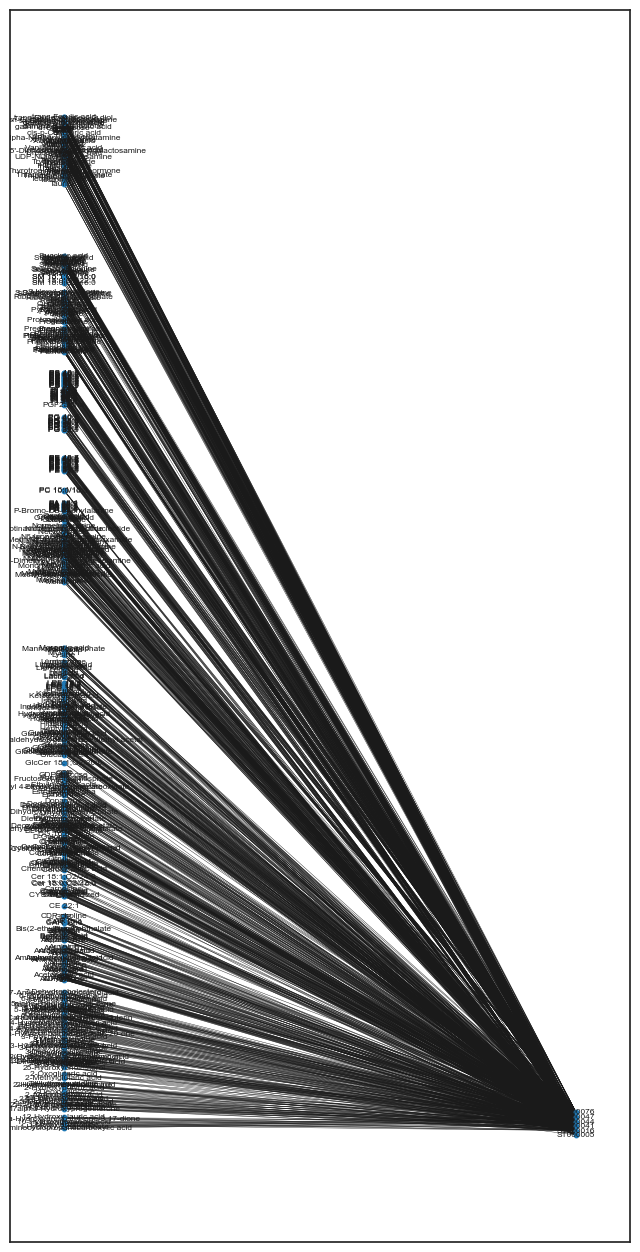

In [186]:
plt.figure(3,figsize=(8,16)) 
nx.draw_networkx(
    B,
    pos = nx.drawing.layout.bipartite_layout(studies, unique_compounds),
    font_size=6,
    width = 0.3,
    with_labels=True,
    node_size=10,
    ) # Or whatever other display options you like

plt.show()

In [215]:
# force directed layout
pos = nx.drawing.layout.kamada_kawai_layout(B)
color_map = []
labels = {}
for node in B.nodes:
    if node in bipartite_nodes:
        print(node)
        color_map.append('red')
        # labels[node] = study_labels[node]
    else: 
        color_map.append('blue')    
        # labels[node] = ''  


plt.figure(3,figsize=(10 ,10)) 
nx.draw_networkx(
    B,
    pos = pos,
    font_size=6,
    width = 0.3,
    with_labels=False,
    node_size=10,
    node_color=color_map
    ) # Or whatever other display options you like
# nx.draw_networkx_labels(covid_bpt, pos, labels,
#                         bbox = dict(facecolor = "red", alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'),
#                         font_size=8,
#                         font_color='black')

plt.show()

KeyboardInterrupt: 

Total number of overlapping REFMETS between each study
- 

In [243]:
bipartite_nodes

['ST000005',
 'ST000016',
 'ST000041',
 'ST000044',
 'ST000047',
 'ST000076',
 'ST000106',
 'ST000110',
 'ST000110',
 'ST000113',
 'ST000114']

In [242]:
biadj_mat = nx.bipartite.biadjacency_matrix(B, row_order=bipartite_nodes, column_order=unique_compounds).toarray()

# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat = pd.DataFrame(biadj_mat @ biadj_mat.T, index=list(bipartite_nodes), columns=list(bipartite_nodes))

NetworkXError: Ambiguous ordering: `row_order` contained duplicates.

In [238]:
adj_mat

,ST000005,ST000016,ST000041,ST000044,ST000047,ST000076
ST000005,271,6,20,22,8,103
ST000016,6,422,331,336,87,35
ST000041,20,331,427,363,92,43
ST000044,22,336,363,495,103,51
ST000047,8,87,92,103,126,18
ST000076,103,35,43,51,18,306


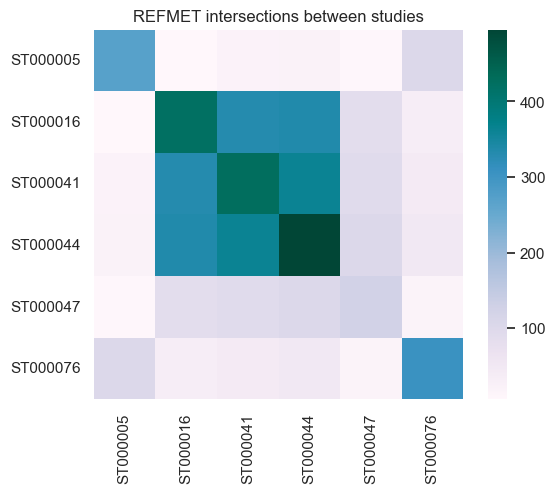

In [239]:
sns.set(
    style='white'
)
ax = sns.heatmap(
    data=adj_mat,
    square=True,
    cmap='PuBuGn',
)

ax.set_title('REFMET intersections between studies')
plt.show()